# **Mini Project 1**

0. Requirements:
   
   If you do not have the following packages installed, run the command below to install them.

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install codecarbon
!pip install shap

1. Data Preparation:
   
    Goal: Load and inspect the IMDb dataset containing movie reviews labeled with positive and negative sentiments.(https://ai.stanford.edu/%7Eamaas/data/sentiment/)
    
    Task: Read the dataset, store the reviews and their associated sentiments, and explore the dataset to understand its structure.

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker

# TASK 1: Data Preparation 

# ======================================================================
# =========== Load the dataset from the local aclImdb folder ===========
# ======================================================================

# Define the folders to process
folders = [
    './aclImdb/test/neg',
    './aclImdb/test/pos', 
    './aclImdb/train/neg',
    './aclImdb/train/pos'
]

# Process each folder and collect data
data = []
for folder in folders:                                                                  # Iterate through each folder in the list
    if os.path.exists(folder):                                                          # Check if the folder exists
        sentiment = 0 if 'neg' in folder else 1                                         # Determine sentiment based on folder name
        for filename in os.listdir(folder):                                             # Iterate through each file in the folder
            if filename.endswith('.txt'):                                   
                file_path = os.path.join(folder, filename)                              # Construct the full file path
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:                # Open the file with UTF-8 encoding
                        review_text = file.read().strip()                               # Read the review text and remove leading/trailing whitespace
                    data.append({'review': review_text, 'sentiment': sentiment})        # Append the review and sentiment to the data list
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")                            # Print an error message if there is an issue reading the file

# Create dataframe from collected data
dataset = pd.DataFrame(data, columns=['review', 'sentiment'])

# ======================================================================
# ==== Specify the path to the train folder in the aclImdb dataset =====
# ======================================================================
train_folder = './aclImdb/train'

# ======================================================================
# ======================== Inspect the dataset =========================
# ======================================================================
print(dataset.head())
print(dataset['sentiment'].value_counts())

                                              review  sentiment
0  Once again Mr. Costner has dragged out a movie...          0
1  This is an example of why the majority of acti...          0
2  First of all I hate those moronic rappers, who...          0
3  Not even the Beatles could write songs everyon...          0
4  Brass pictures (movies is not a fitting word f...          0
sentiment
0    25000
1    25000
Name: count, dtype: int64


2. Text Preprocessing:
   
    Goal: Clean and preprocess the text data to remove noise and prepare it for analysis.
    
    Task: Remove unnecessary characters (e.g., HTML tags, punctuation), convert text to lowercase, and process words by removing stop words and stemming/lemmatizing them.

In [20]:
# TASK 2: Text Preprocessing 
# Remove HTML tags
dataset['review'] = dataset['review'].apply(lambda x: re.sub('<.*?>', '', x))

# Remove special characters (keep only letters and spaces)
dataset['review'] = dataset['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Convert to lowercase
dataset['review'] = dataset['review'].apply(lambda x: x.lower())

# Remove stop words and perform stemming
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
def crop_review(text):
    words = text.split()                                                            # Split the text into individual words
    filtered_words = [ps.stem(word) for word in words if word not in stop_words]    # Remove stop words and apply stemming
    return ' '.join(filtered_words)                                                 # Join the processed words back into a single string
dataset['review'] = dataset['review'].apply(crop_review)                            # Apply the crop_review function to the 'review' column

3. Feature Extraction:

    Goal: Transform the cleaned text into numerical features for machine learning.
   
    Task: Use a vectorization technique such as TF-IDF to convert the text into a numerical matrix that captures the importance of each word in the dataset.

In [24]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000,   # Limit to top 5000 features
                                   ngram_range=(1, 2),  # Use unigrams and bigrams
                                   min_df=5,            # Ignore words that appear in less than 5 documents
                                   max_df=0.8)          # Ignore words that appear in more than 80% of documents

# Split features and target
X = dataset['review']
y = dataset['sentiment']

# Apply TF-IDF vectorization
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Original text shape: {X.shape}")
print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of features: {len(feature_names)}")

Original text shape: (50000,)
TF-IDF matrix shape: (50000, 5000)
Number of features: 5000


4. Model Training:

    Goal: Train a machine learning model to classify reviews based on their sentiment.
    
    Task: Split the dataset into training and testing sets, train a Logistic Regression model, and evaluate its performance on the test data.

In [34]:
# TASK 4: Model Training 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=1, stratify=y)

# Initialize the Logistic Regression model
lr = LogisticRegression(C=1.0, random_state=1, solver='lbfgs', multi_class='ovr')

# TASK 8: Track emissions during model training
tracker = EmissionsTracker()
tracker.start()

# Train the model
lr.fit(X_train, y_train)

# Stop the emissions tracker and save the results
emissions = tracker.stop()
print(f"CO2 emissions during training: {emissions} kg")

[codecarbon WARNING @ 19:56:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 19:56:27] [setup] RAM Tracking...
[codecarbon INFO @ 19:56:27] [setup] CPU Tracking...
[codecarbon WARNING @ 19:56:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 19:56:27] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz
[codecarbon WARNING @ 19:56:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:56:27] [setup] GPU Tracking...
[codecarbon INFO @ 19:56:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:56:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 19:56:28] >>> Track

CO2 emissions during training: 5.56755210164711e-08 kg


5. Model Evaluation:

    Goal: Assess the performance of your model using appropriate metrics.
    
    Task: Evaluate precision, recall, and F1-score of the Logistic Regression model. Use these metrics to identify the strengths and weaknesses of your system. Visualize the Confusion Matrix to better understand how well the model classifies positive and negative reviews. Additionally, test the model with a new review, preprocess it, make a prediction, and display the result. Example: test it with a new review such as:
    "The movie had great visuals, but the storyline was dull and predictable." The expected output might be: Negative Sentiment.


Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.89      0.88      0.89      2500
Positive (1)       0.88      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



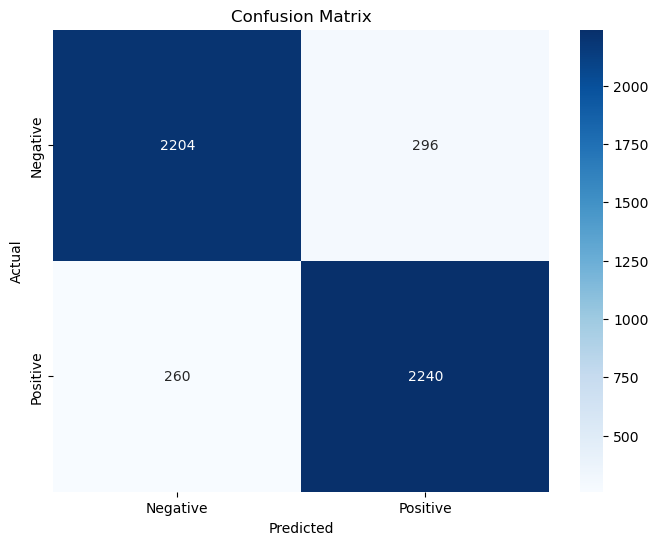


Review: The movie had great visuals but the storyline was dull and predictable.
Prediction: Negative


In [35]:
# TASK 5: Model Evaluation 

# Make predictions
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with a new review
review = "The movie had great visuals but the storyline was dull and predictable."
review_tfidf = tfidf_vectorizer.transform([review])
prediction = lr.predict(review_tfidf)
probability = lr.predict_proba(review_tfidf)

print(f"\nReview: {review}")
print(f"Prediction: {'Positive' if prediction[0] == 1 else 'Negative'}")

6. Hyperparameter Tuning:

    Goal: Optimize your Logistic Regression model by tuning its hyperparameters.
   
    Task: Use an optimization method to find the best parameters for your model and improve its accuracy.

In [33]:
# TASK 6: Hyperparameter Tuning 
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
gs = GridSearchCV(estimator=lr, 
                  param_grid={'C': param_range}, 
                  scoring='accuracy', 
                  cv=10, 
                  n_jobs=-1)

# TASK 8: Track emissions during Hyperparameter Tuning
tracker_hp = EmissionsTracker()
tracker_hp.start()

# Perform Grid Search to find the best C parameter
gs.fit(X_train, y_train)

# Stop the emissions tracker and save the results
emissions = tracker_hp.stop()
print(f"CO2 emissions during training: {emissions} kg")

# Print the best C parameter found by GridSearchCV
print(f"Best C parameter: {gs.best_params_['C']}")

[codecarbon WARNING @ 19:55:29] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 19:55:29] [setup] RAM Tracking...
[codecarbon INFO @ 19:55:29] [setup] CPU Tracking...
[codecarbon WARNING @ 19:55:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 19:55:29] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz
[codecarbon WARNING @ 19:55:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:55:29] [setup] GPU Tracking...
[codecarbon INFO @ 19:55:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:55:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 19:55:30] >>> Track

CO2 emissions during training: 1.8594636201440135e-06 kg
Best C parameter: 1.0


7. Learning Curve Analysis:

    Goal: Diagnose your model's performance by plotting learning curves.
   
    Task: Analyze training and validation performance as a function of the training set size to identify underfitting or overfitting issues.


c:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_clas

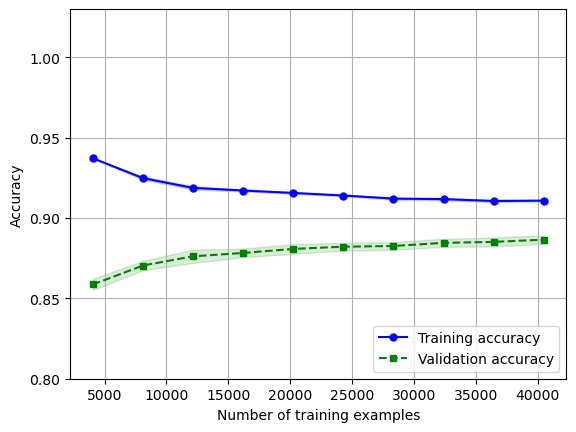

In [36]:
# TASK 7: Learning Curve Analysis
train_sizes, train_scores, test_scores =\
    learning_curve(estimator=lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std, 
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std, 
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

9. Ethical Considerations and Explainability:

    Goal: Discuss the ethics in using and deploying your AI-based solution by investigating and implementing suitable explainability methods.
    
    Task: Understanding how a machine learning model makes predictions is crucial for ensuring transparency, fairness, and accountability in AI deployment. One of the widely used techniques for model explainability is SHAP (SHapley Additive exPlanations), which helps determine how much each feature (word) contributes to a prediction.
    In this task, you will use SHAP to analyze the impact of individual words on sentiment classification. This will allow you to visualize which words increase or decrease the probability of a positive or negative sentiment prediction. Additionally, discuss key aspects such as potential biases in the model, fairness in outcomes, and accountability in AI decision-making. You can find more information here: https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html

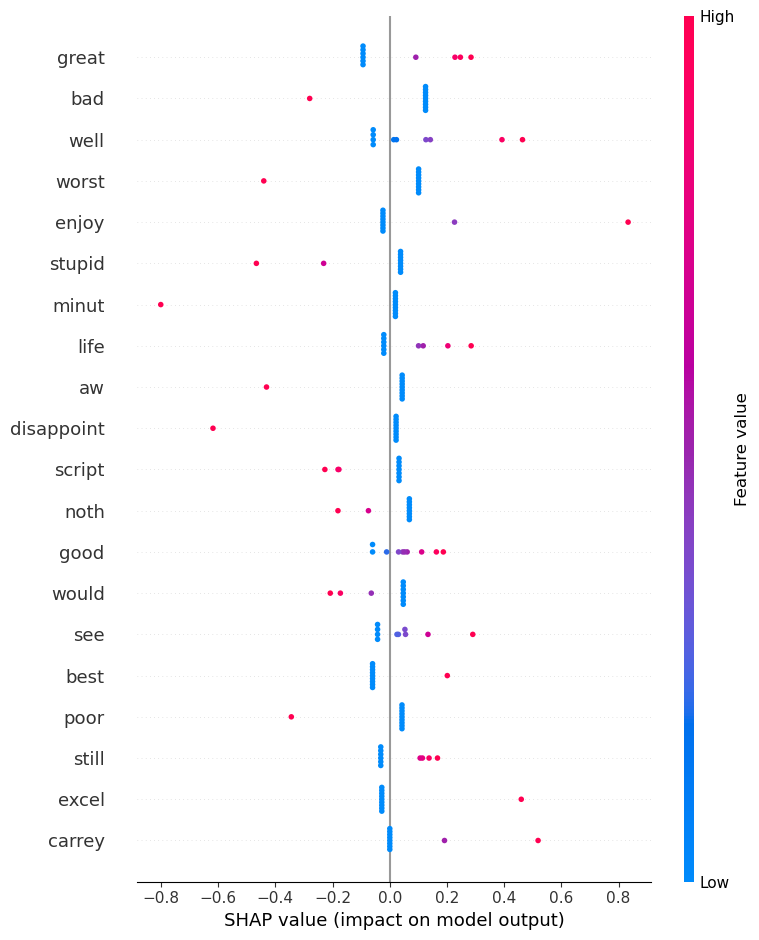

In [8]:
# TASK 9: Ethical Considerations & Explainability

# Show SHAP summary plot with proper feature names


10. Deployment Considerations for Embedded Systems:

    Goal: Optimize and convert the trained logistic regression model for deployment on embedded systems like Arduino
    
    Task: To deploy the trained logistic regression model on a resource-constrained embedded system like an Arduino, we must optimize and convert the model into a format suitable for execution in an environment with limited memory and processing power. Since embedded systems do not support direct execution of machine learning models trained in Python, we extract the model’s learned parameters—namely, the weights and bias—after training. These parameters are then quantized to fixed-point integers to eliminate the need for floating-point calculations, which are inefficient on microcontrollers.
    Once quantization is applied, we generate a C++ .h header file containing the model’s coefficients and bias, formatted in a way that allows direct use within an Arduino sketch. The final model is optimized to perform inference using integer arithmetic, making it both lightweight and efficient for deployment on microcontrollers. You can find more information here: https://medium.com/@thommaskevin/tinyml-binomial-logistic-regression-0fdbf00e6765

In [9]:
# TASK 10: Deployment Considerations (Model Quantization & Export for Arduino)
# Extract weights and bias from the trained logistic regression model

# Apply quantization (convert to fixed-point representation)

# Generate C++ header file for Arduino

# Save the header file


Quantized model parameters saved to sentiment_model.h
